In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

In [16]:
batch_size = 64
image_size = 224
# model_name = 'stage-8-256-rn50-exported'
model_name = 'rn50-stage2-v1'
resnet = models.resnet50
metrics = {'train': {}, 'validation': {}, 'test': {}}

In [17]:
train = pd.read_csv(os.path.join(cfg.csv_dir, 'train_upsampled_multilabel.csv'))
validation = pd.read_csv(os.path.join(cfg.csv_dir, 'validation_multilabel.csv'))
train['imagename'] = train['imagename'].map(lambda x: f"train/{x}")
validation['imagename'] = validation['imagename'].map(lambda x: f"validation/{x}")
df = pd.concat([train, validation])
df.reset_index(inplace=True, drop=True)

assert df.shape[0] == train.shape[0] + validation.shape[0]

In [18]:
test = pd.read_csv(os.path.join(cfg.csv_dir, 'test_multilabel.csv'))

In [19]:
# np.random.seed(42)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

src = (ImageList.from_df(path=cfg.img_path, df=df)
       .split_by_idx(valid_idx=range(train.shape[0], df.shape[0]))
       .label_from_df(cols='label', label_delim=' '))

src_test = (ImageList.from_df(path=cfg.img_path_test, df=test, folder='hold-out')
       .split_none()
       .label_from_df(label_delim=' '))

In [20]:
data = (src.transform(tfms, size=image_size)
        .databunch().normalize(imagenet_stats))

data_test = (src_test.transform(tfms, size=image_size)
        .databunch().normalize(imagenet_stats))

acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, resnet, metrics=[acc_05, f_score])

In [21]:
learn = learn.load(os.path.join(cfg.models_dir, model_name)).to_fp16()

In [22]:
train_preds, train_y, train_losses = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)

In [23]:
valid_preds, valid_y, valid_losses = learn.get_preds(with_loss=True)

In [24]:
torch.save(train_preds, os.path.join(cfg.output_path, f'{model_name}_train_preds.pt'))
torch.save(train_y, os.path.join(cfg.output_path, f'{model_name}_train_y.pt'))
torch.save(train_losses, os.path.join(cfg.output_path, f'{model_name}_train_losses.pt'))

torch.save(valid_preds, os.path.join(cfg.output_path, f'{model_name}_valid_preds.pt'))
torch.save(valid_y, os.path.join(cfg.output_path, f'{model_name}_valid_y.pt'))
torch.save(valid_losses, os.path.join(cfg.output_path, f'{model_name}_valid_losses.pt'))
           

In [25]:
metrics['train']['losses_mean'] = train_losses.mean().item()
metrics['validation']['losses_mean'] = valid_losses.mean().item()
print(metrics)

{'train': {'losses_mean': 0.3446654677391052}, 'validation': {'losses_mean': 0.18537059426307678}, 'test': {}}


In [36]:
def calc_metric_score(y=None, preds=None, metric=None, threshold=None):
    if threshold:
        preds = preds > threshold

    return(metric(y, preds))
            

def calc_threshold_metric_score(y=None, preds=None, metrics=[], thresholds=np.arange(.05, 1, 0.05)):
    output = {}
    for threshold_i in thresholds:
        for metric_i in metrics:
            key_name = f"{metric_i.__name__}_@{threshold_i:.2f}"
            output[key_name] = calc_metric_score(y=y,
                                                      preds=preds,
                                                      metric=metric_i,
                                                      threshold=threshold_i)
    return(output)
    
    

In [43]:
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

f1_score_micro = partial(f1_score, average='micro')
f1_score_micro.__name__ = 'f1_score'
threshold_metrics = [accuracy_score, hamming_loss, f1_score_micro]


metrics['train'] = {**metrics['train'], **calc_threshold_metric_score(y=train_y,
                                                                    preds=train_preds,
                                                                    metrics=threshold_metrics)}


metrics['validation'] = {**metrics['validation'], **calc_threshold_metric_score(y=valid_y, 
                                                           preds=valid_preds,
                                                           metrics=threshold_metrics)}


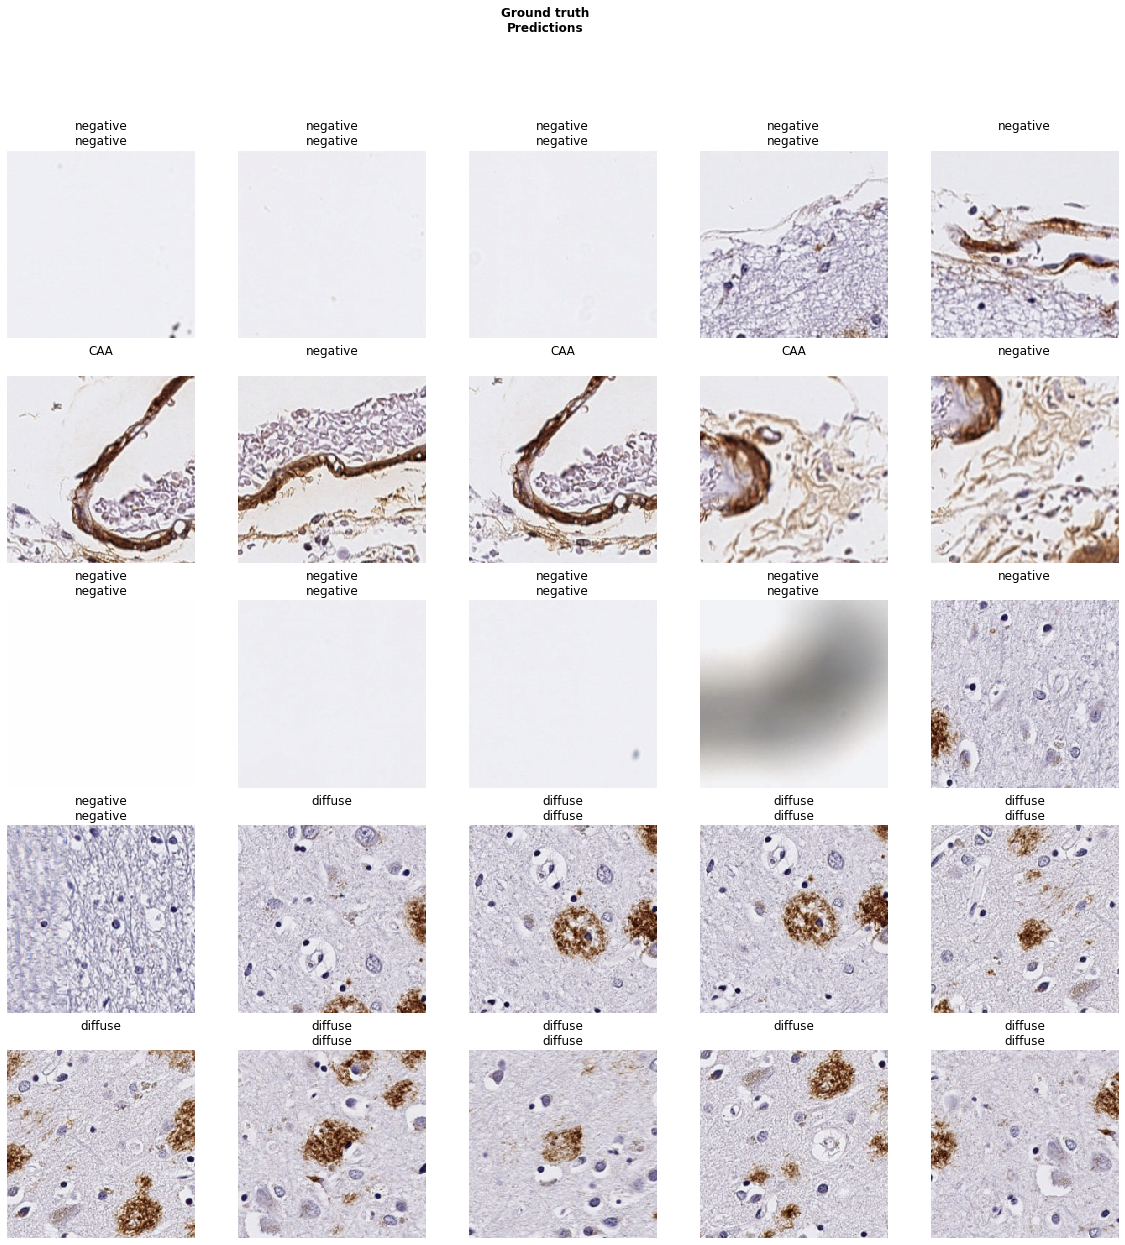

In [44]:
learn.show_results()

saved
saved


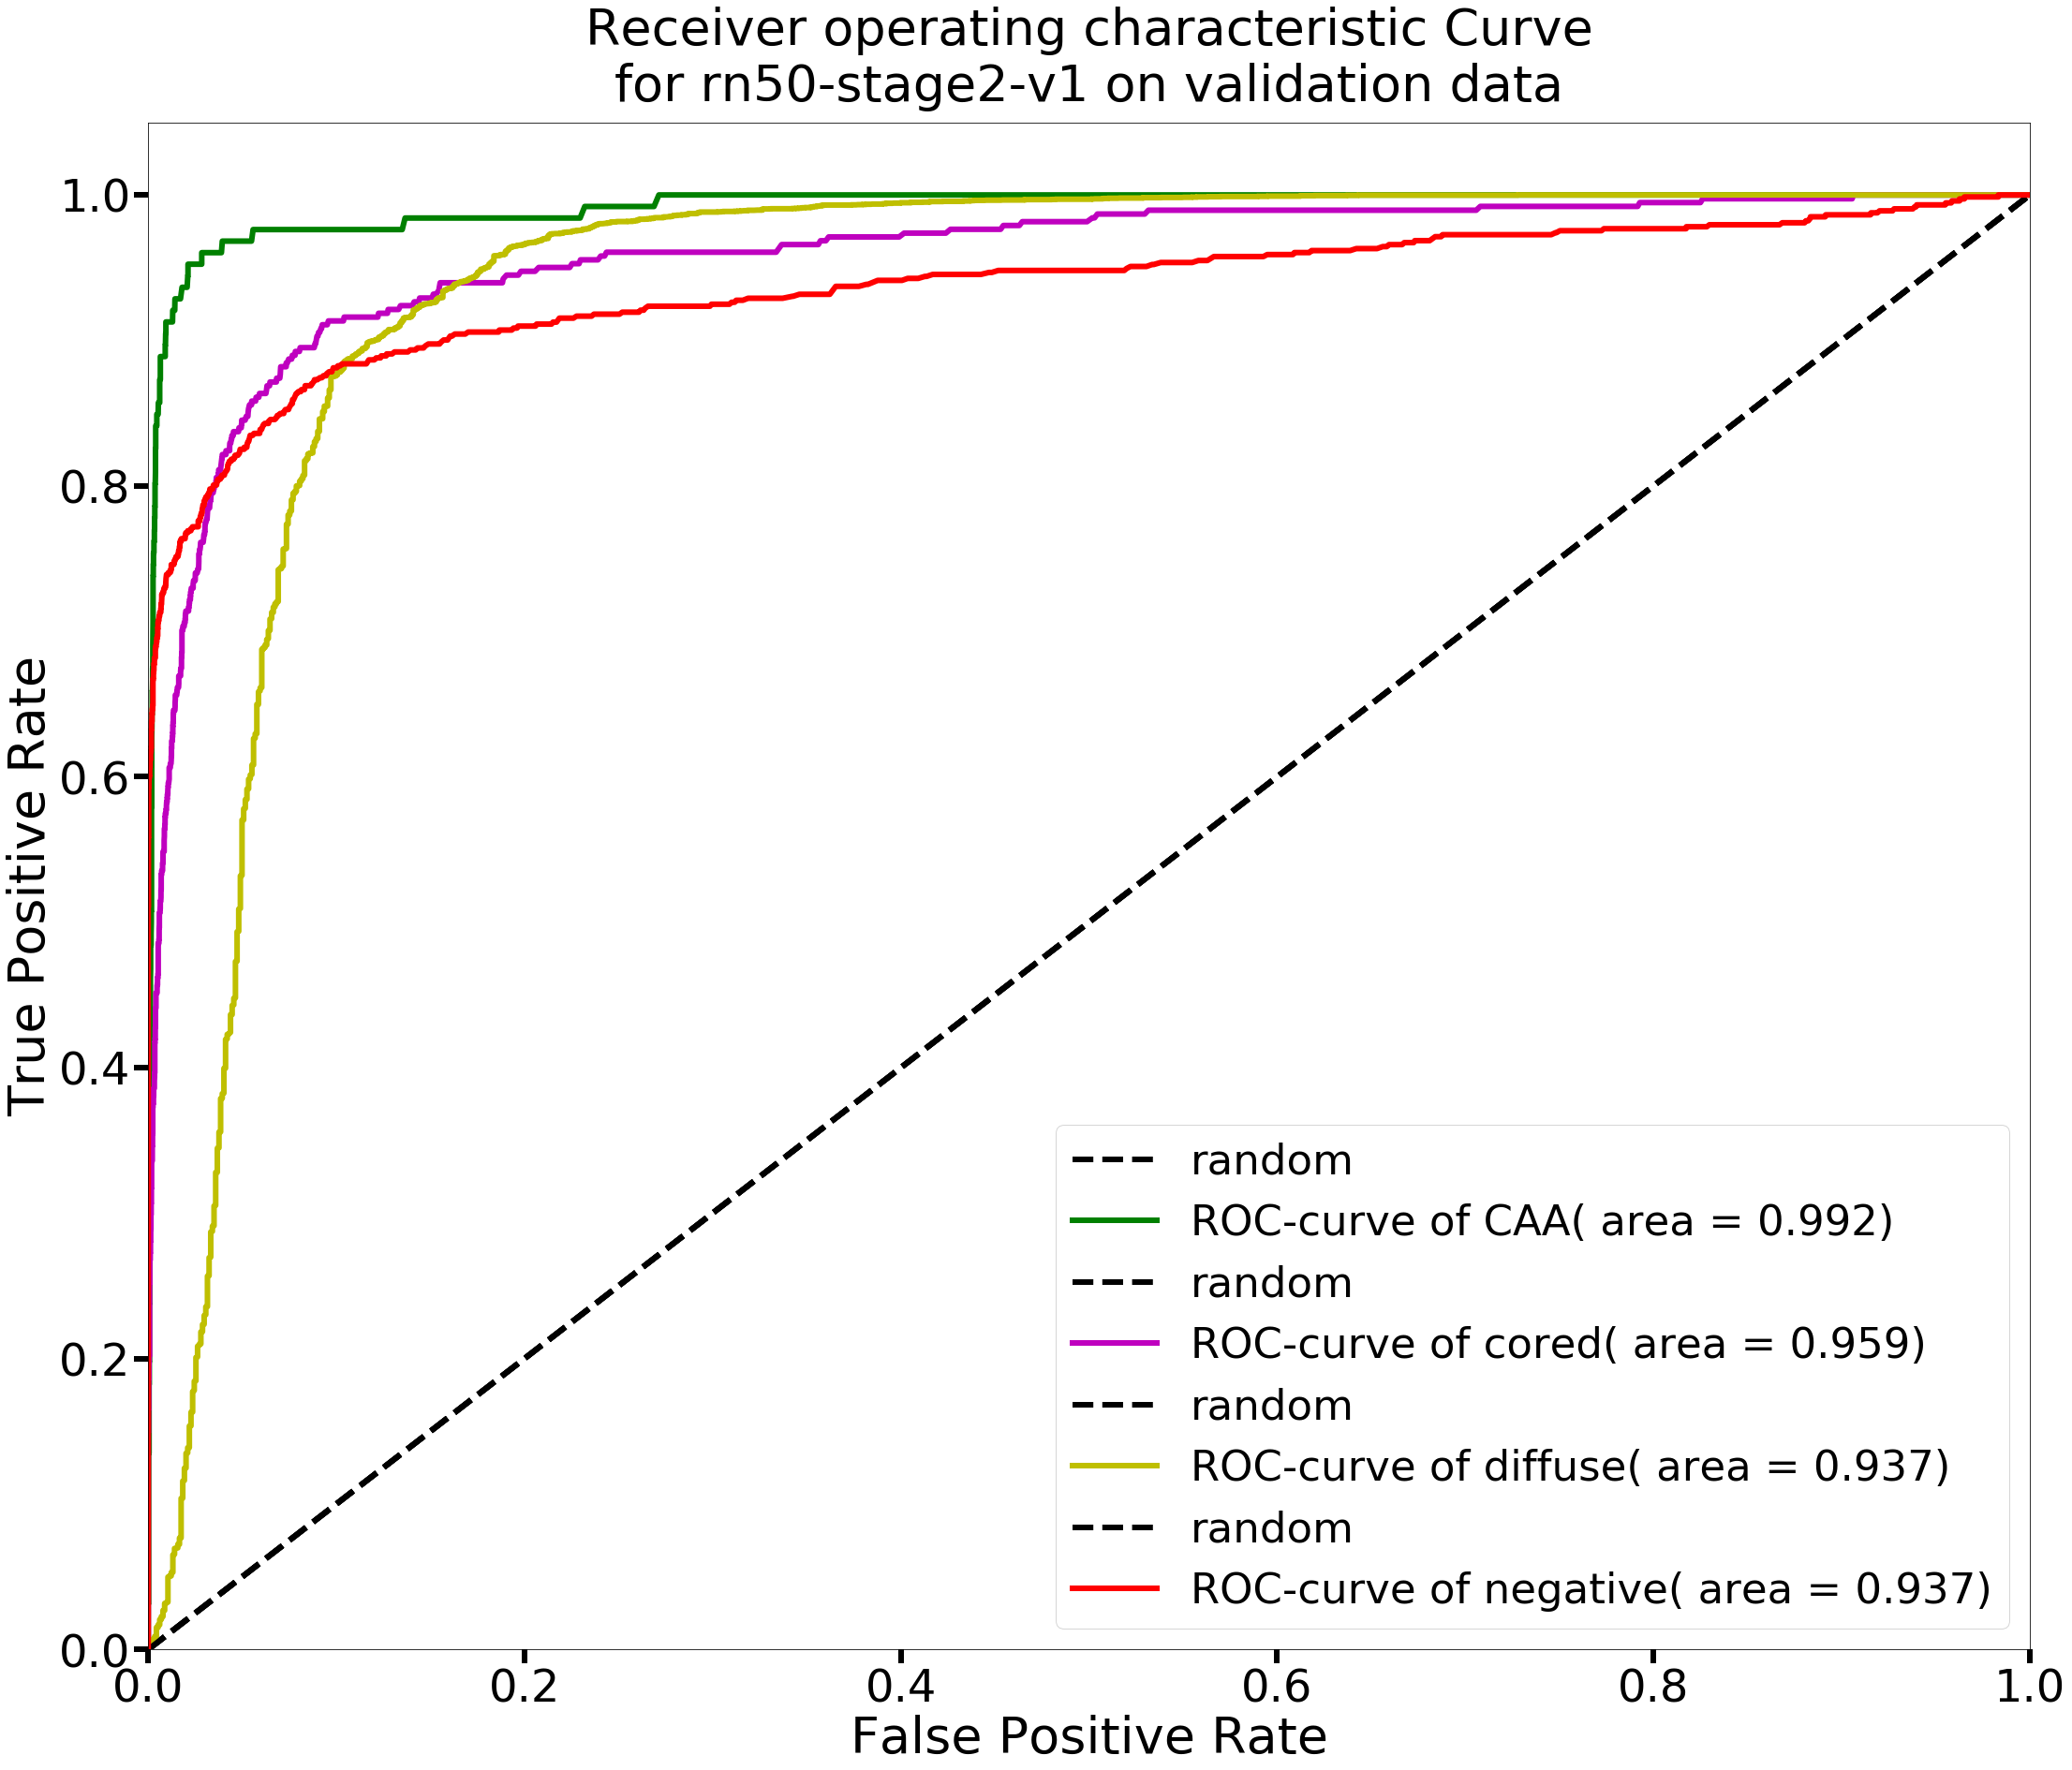

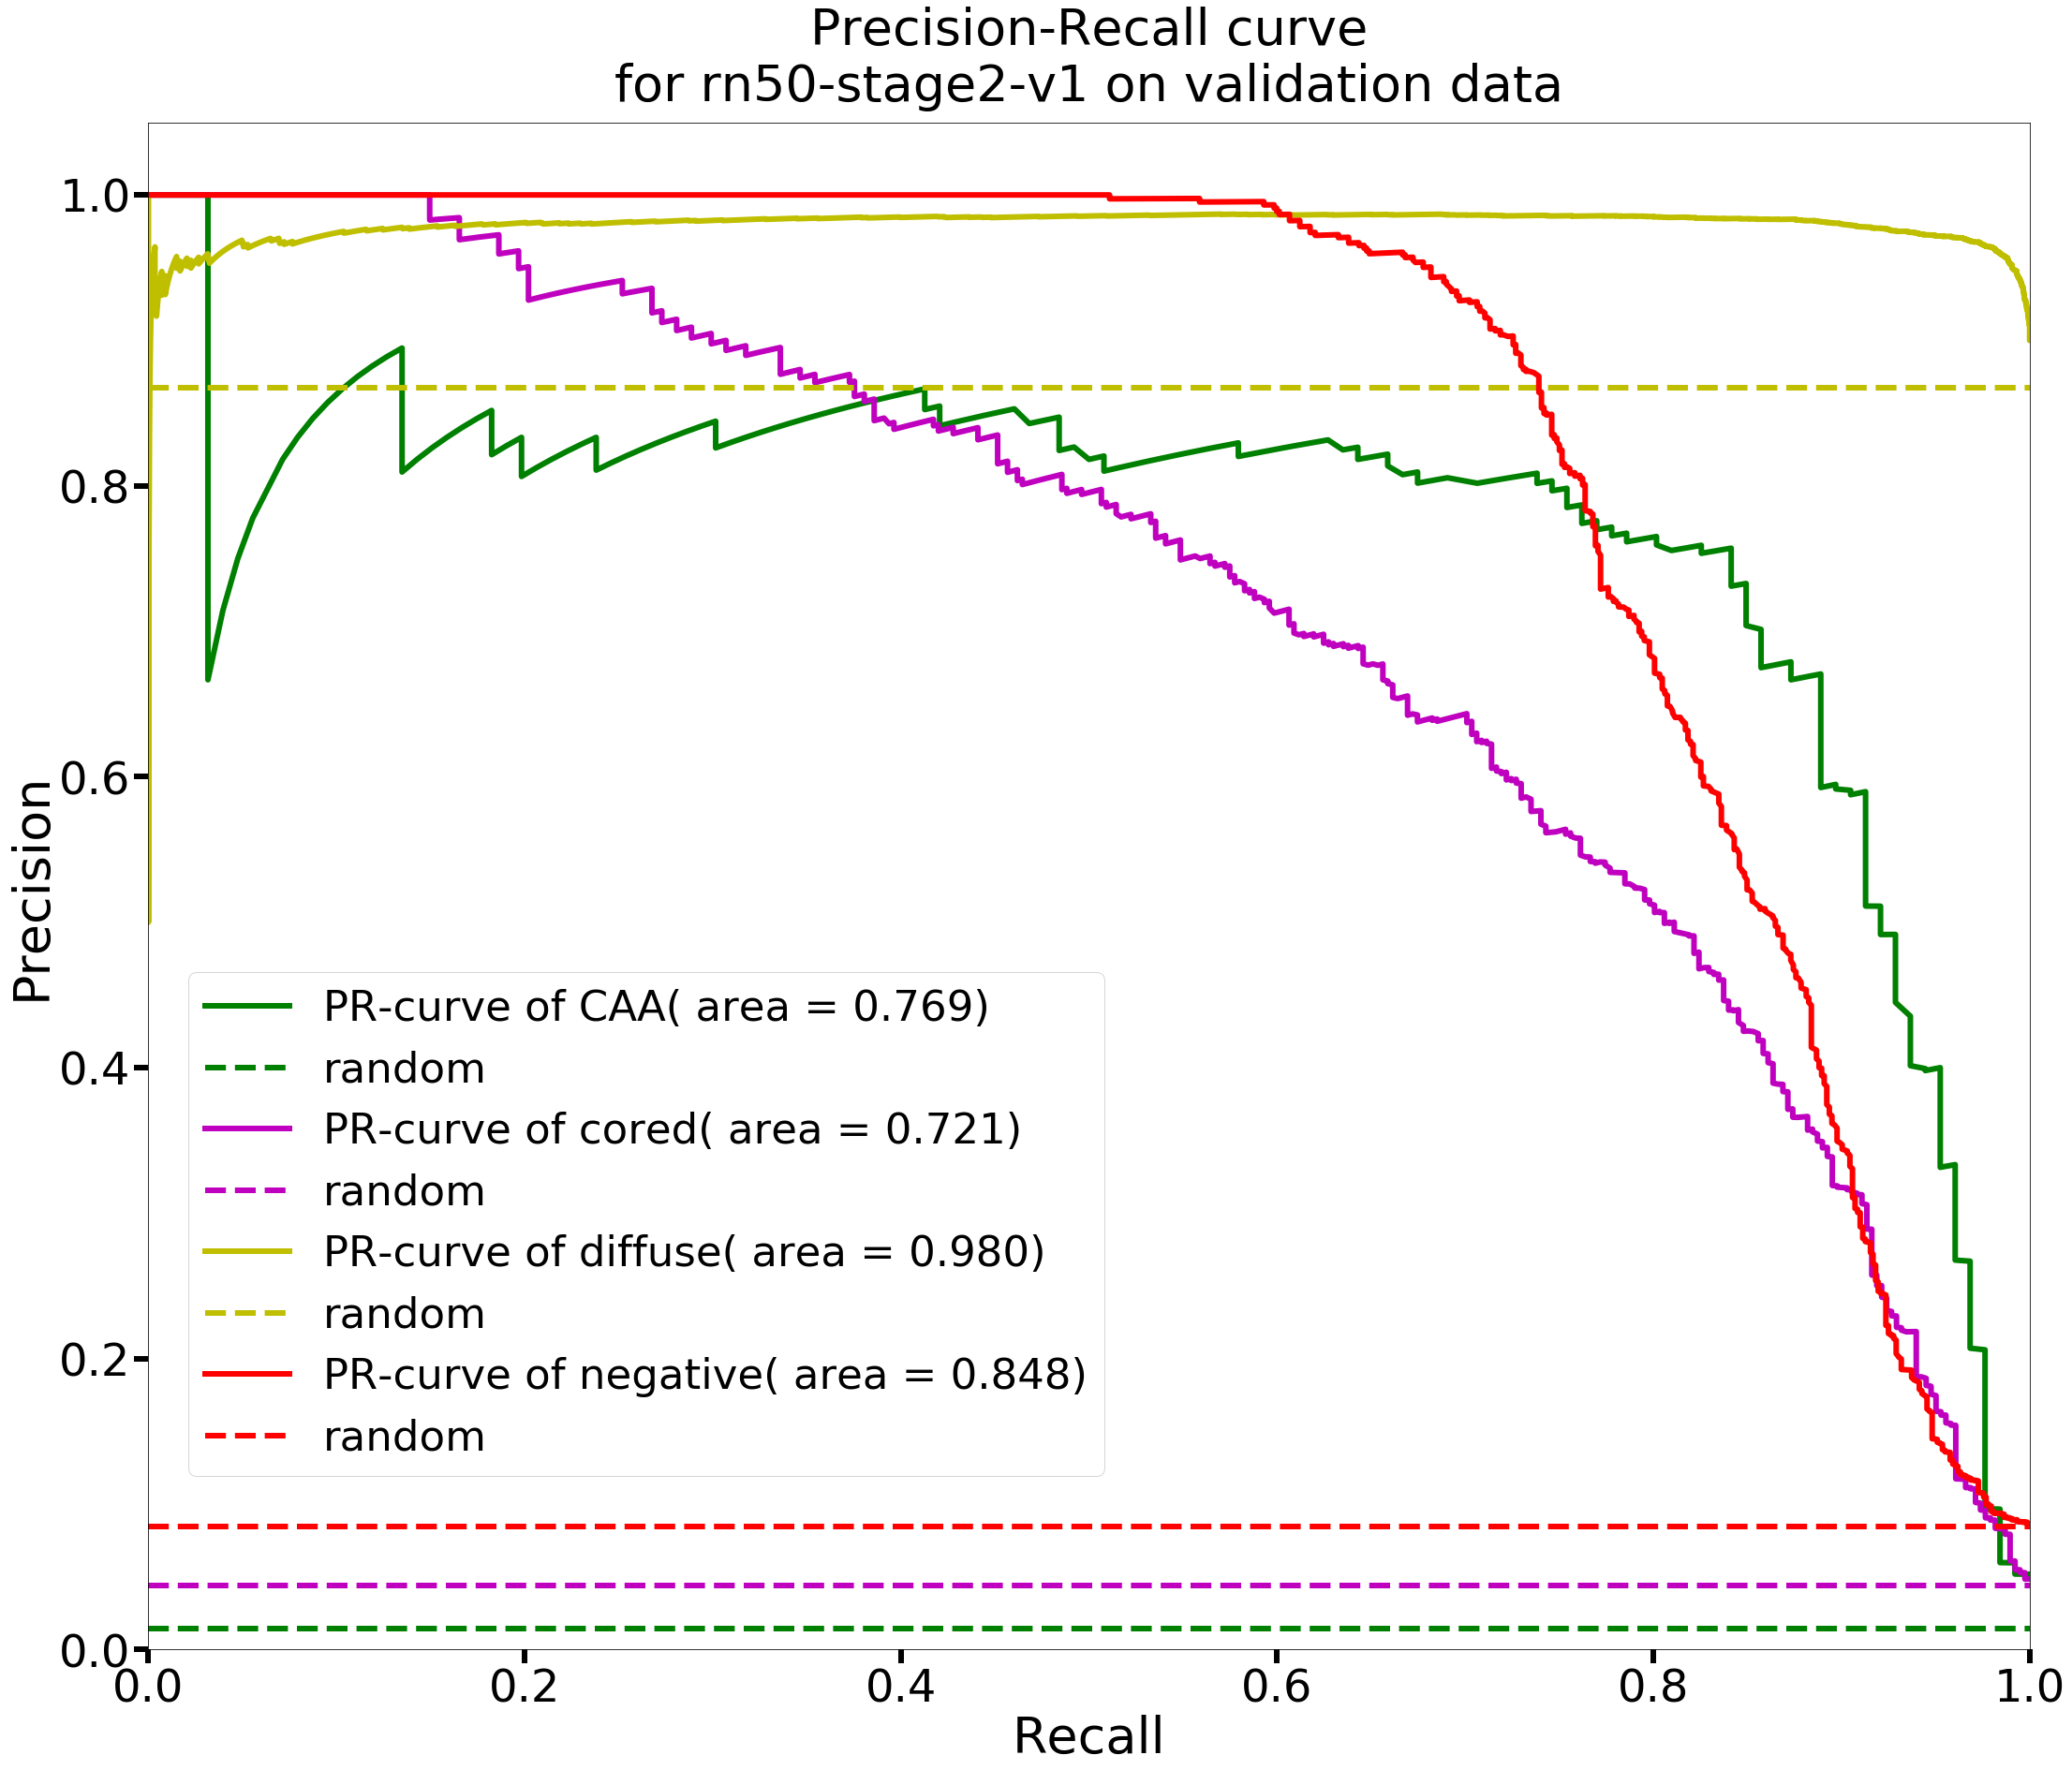

In [45]:
from utils import plot
roc = plot.roc(valid_preds.numpy(), valid_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_roc_plot.png'),
         model_name=model_name, dataset='validation')
prc = plot.prc(valid_preds.numpy(), valid_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_prc_plot.png'),
         model_name=model_name, dataset='validation')

metrics['validation'] = {**metrics['validation'], **roc, **prc}

## Test Set

In [47]:
learn.data.valid_dl = data_test.train_dl
learn = learn.to_fp16()
learn.validate(metrics=[acc_05, f_score])

[0.15466672, tensor(0.9474), tensor(0.9605)]

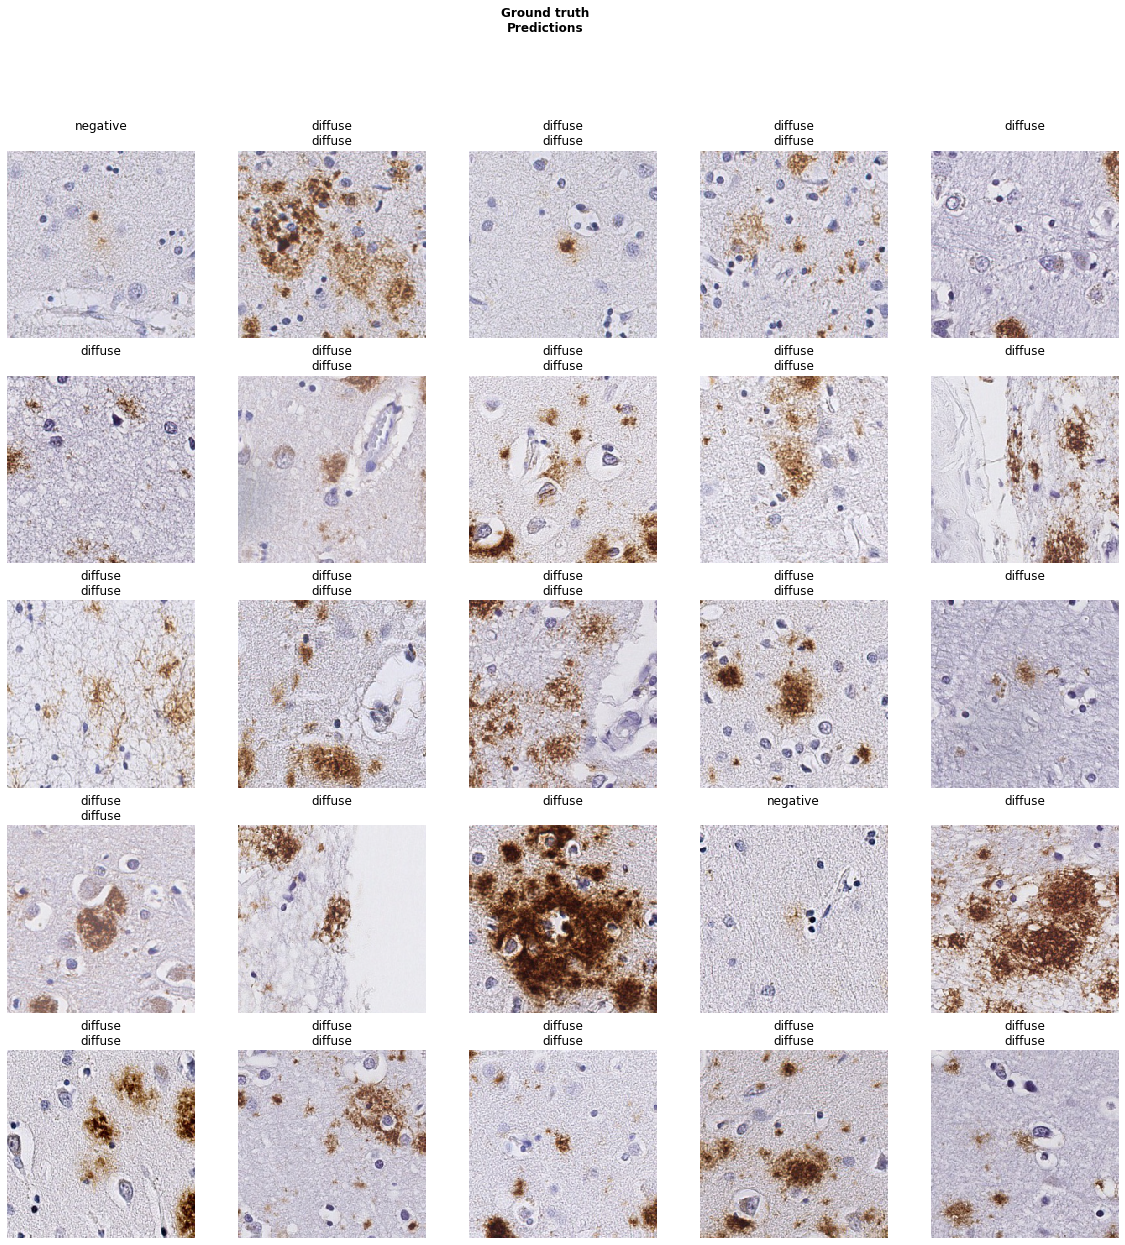

In [48]:
learn.show_results()

In [49]:
test_preds, test_y, test_losses = learn.get_preds(with_loss=True)

In [50]:
torch.save(test_preds, os.path.join(cfg.output_path, f'{model_name}_test_preds.pt'))
torch.save(test_y, os.path.join(cfg.output_path, f'{model_name}_test_y.pt'))
torch.save(test_losses, os.path.join(cfg.output_path, f'{model_name}_test_losses.pt'))

saved
saved


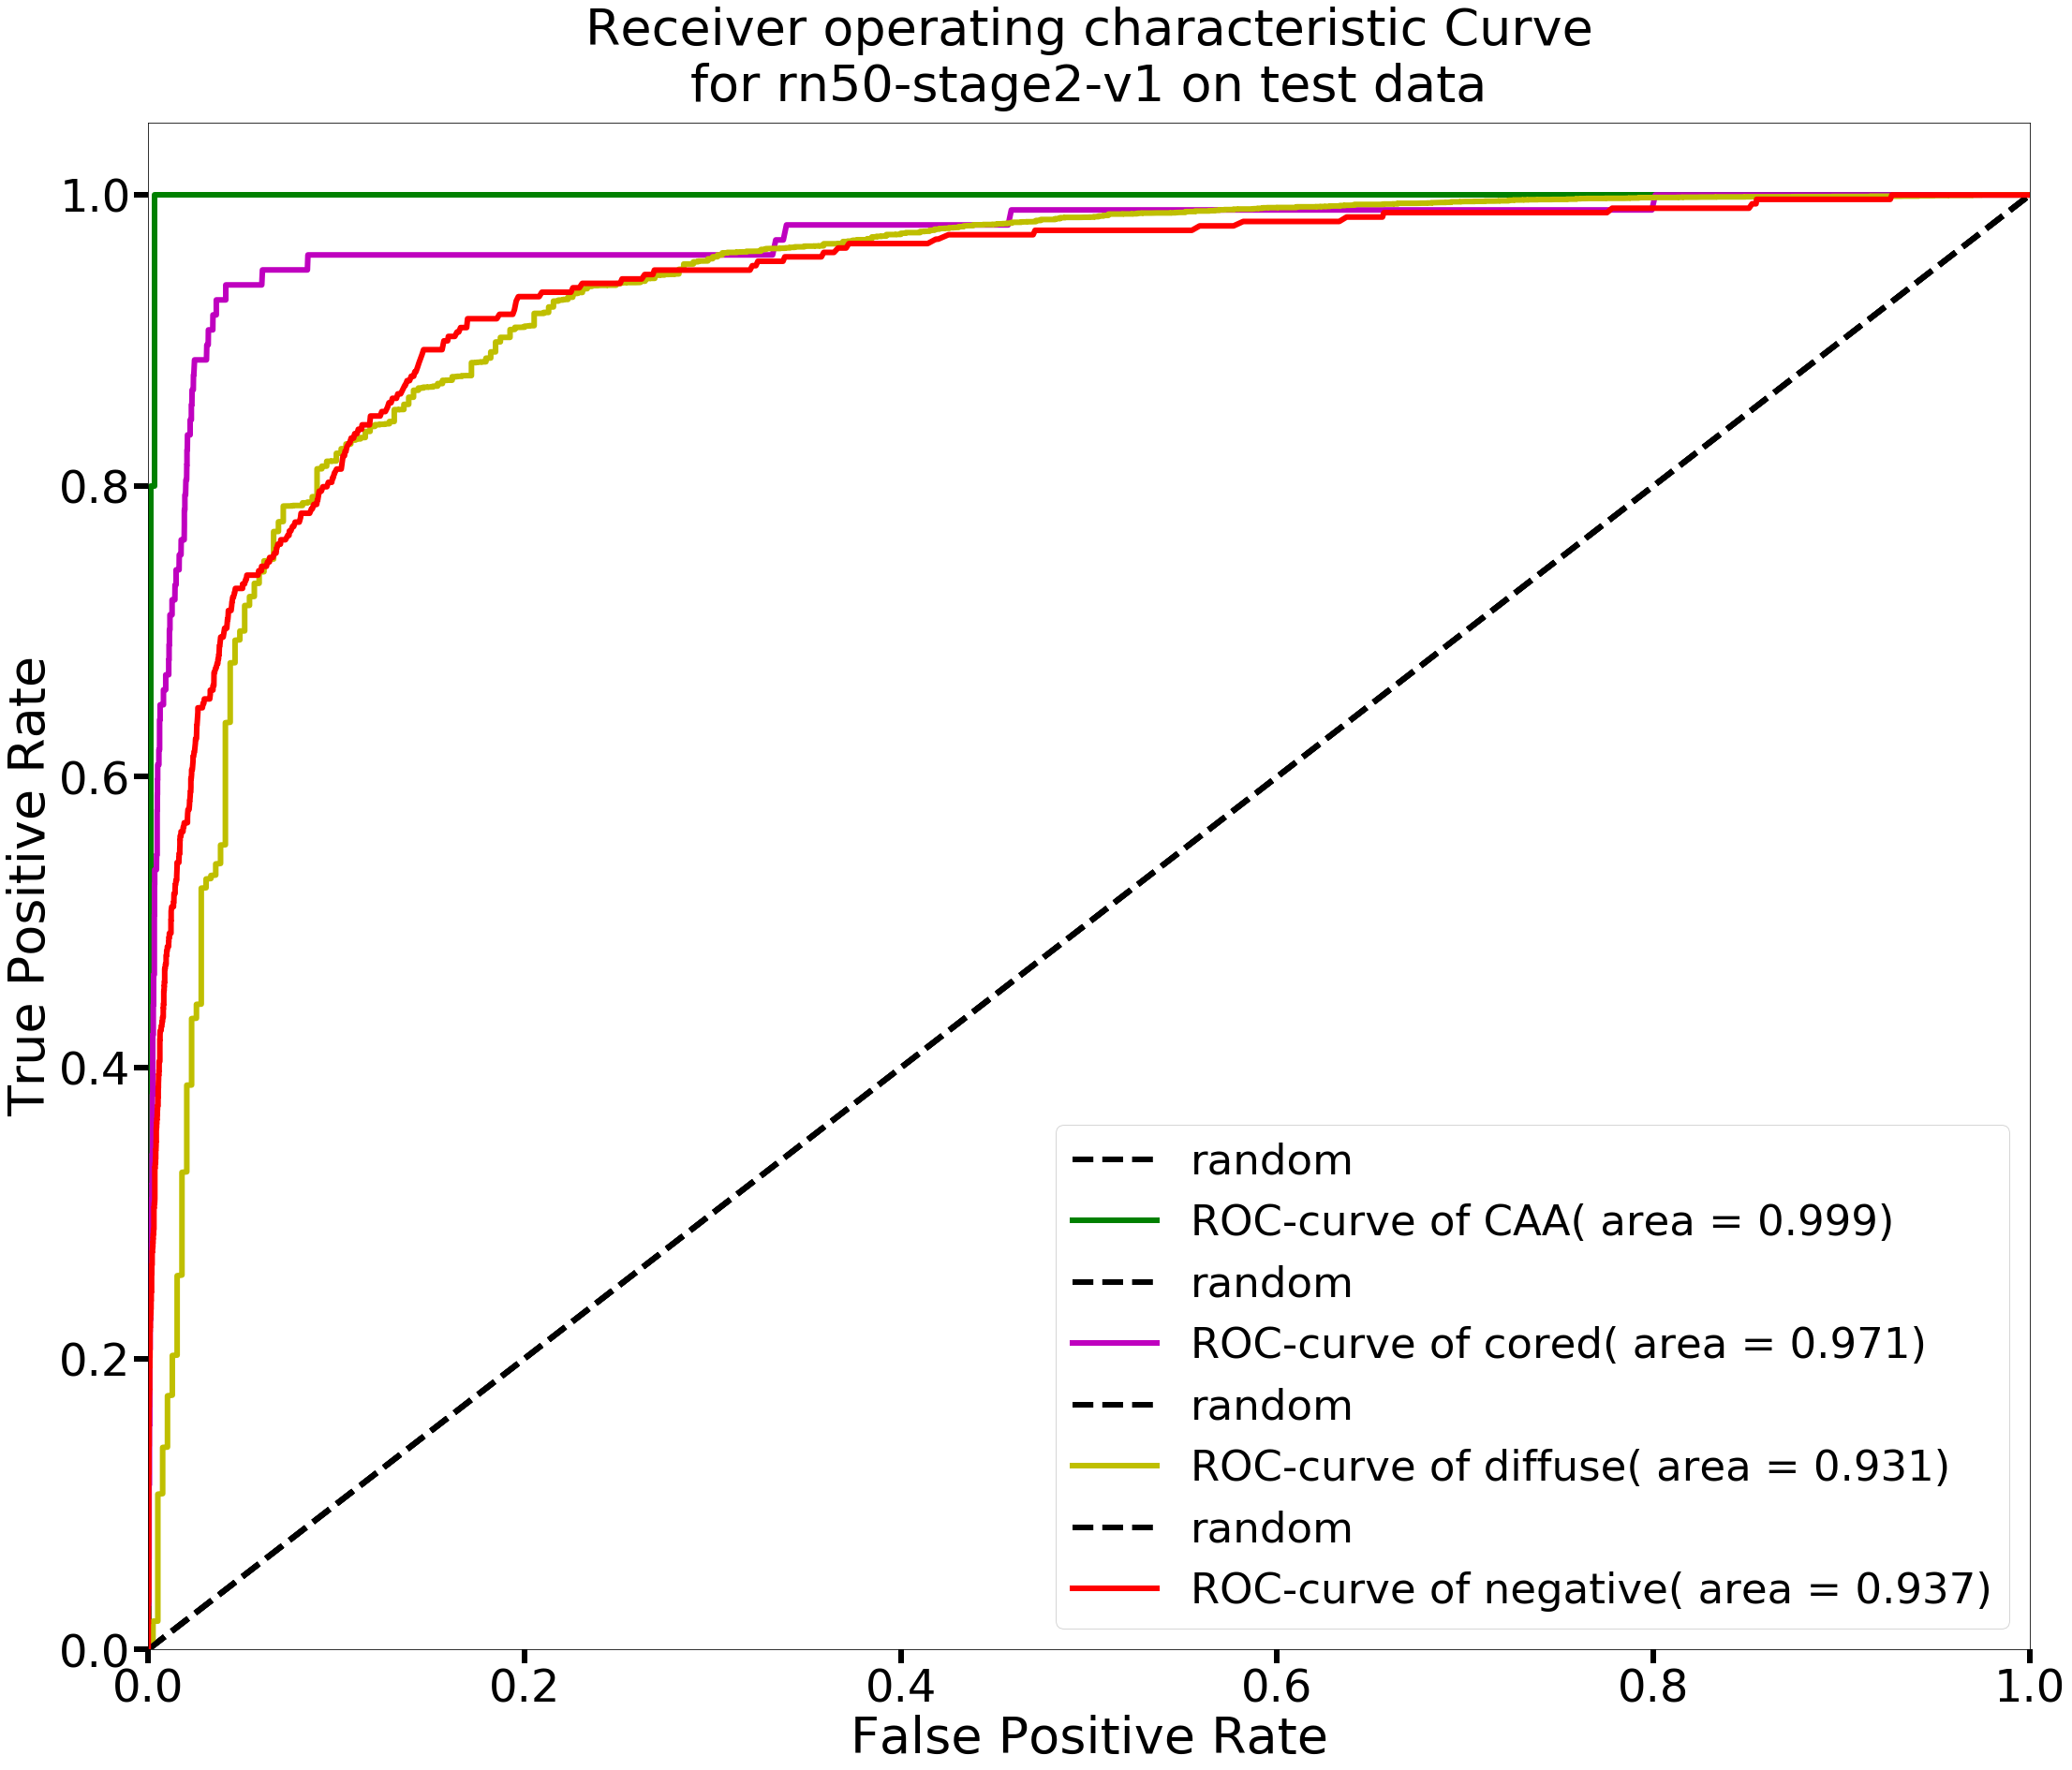

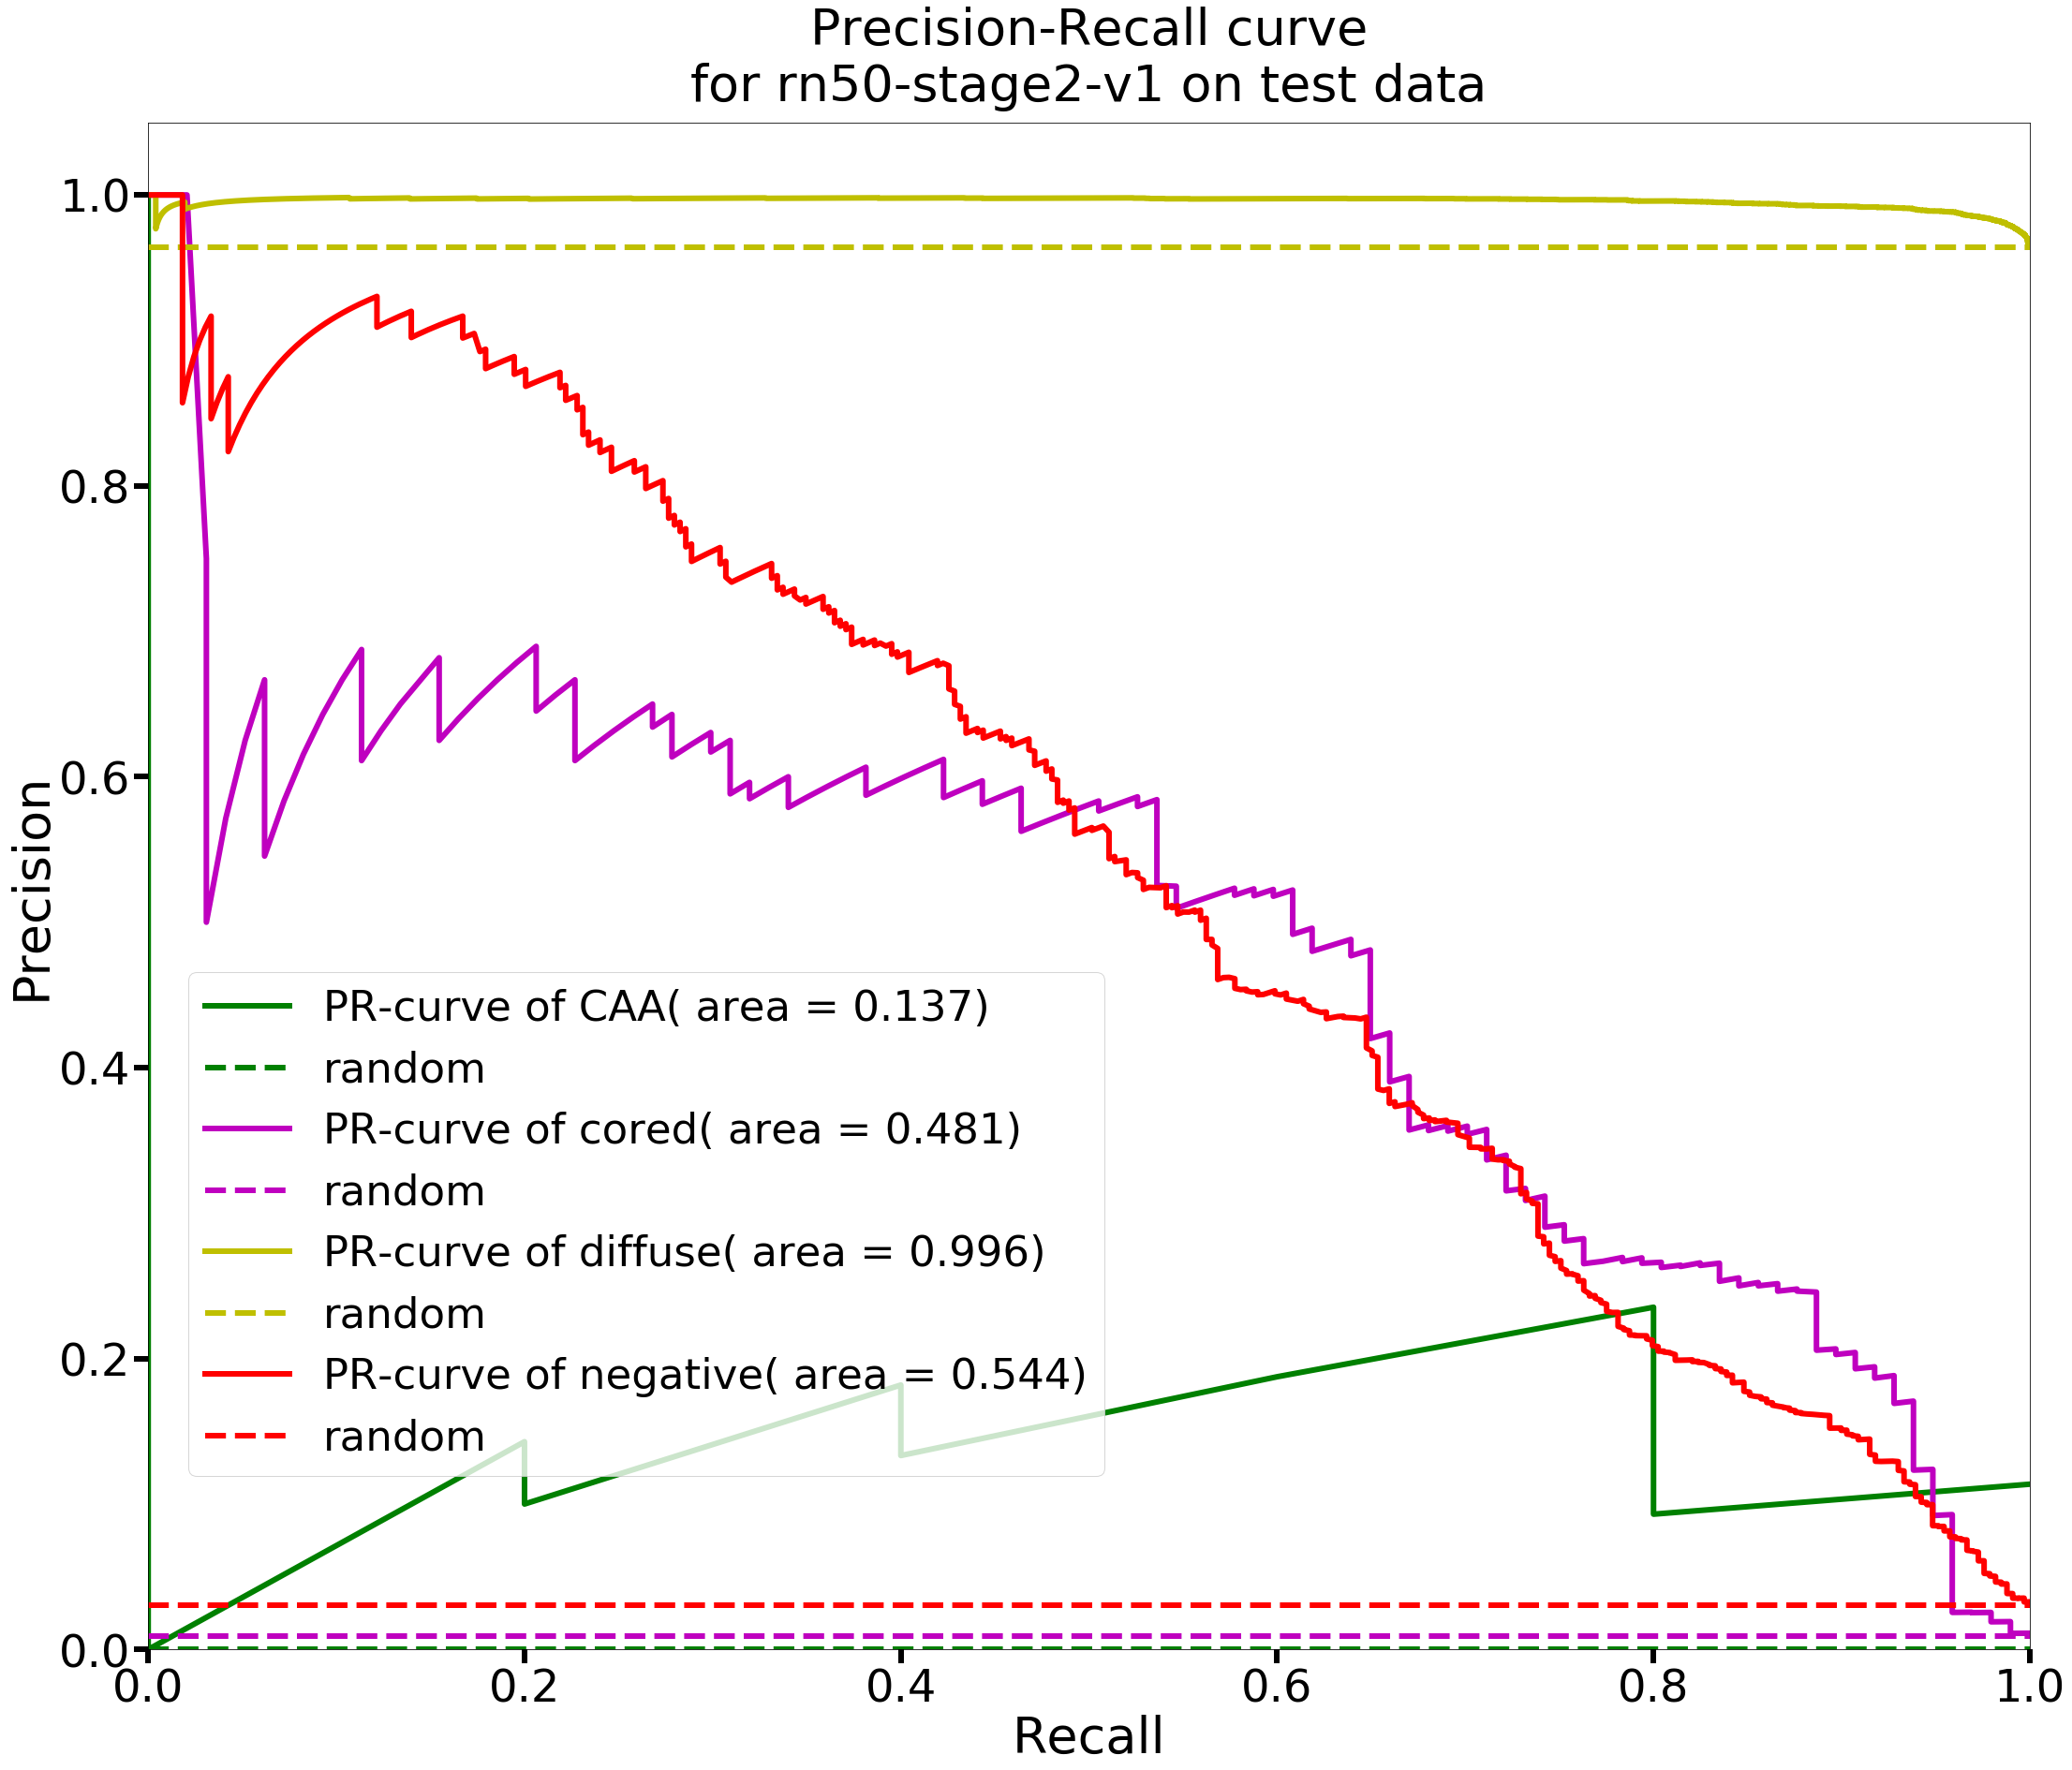

In [51]:
roc = plot.roc(test_preds.numpy(), test_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_roc_plot_test.png'),
         model_name=model_name, dataset='test')
prc = plot.prc(test_preds.numpy(), test_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_prc_plot_test.png'),
         model_name=model_name, dataset='test')
metrics['test'] = {**metrics['test'], **roc, **prc}

In [63]:
def losses_reshape(losses, classes=[]):
    l = losses.numpy()
    n_classes = len(classes)
    losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/n_classes), n_classes)),
                             columns=classes)
    return(losses_df)

def get_top_agg_losses(df, n=10, target_class=None):
    
    if not target_class:
        target_class = 'loss'
    
    df['loss'] = pd.DataFrame(df.sum(axis=1), columns=['loss'])
    df = df.sort_values([target_class], ascending=False)
    
    return(df.iloc[0:n])

def plot_top_losses(preds=None,
                    y=None,
                    losses=None,
                    learner=None,
                    target_class=None,
                    n=10,
                    figsize=(128,128)):
    classes=learn.data.classes
    losses_df = losses_reshape(losses, classes=classes)
    losses_df = get_top_agg_losses(losses_df, n=n, target_class=target_class)
    preds_df = pd.DataFrame(preds.numpy(), columns=classes)
    y_df = pd.DataFrame(y.numpy(), columns=classes)
    classes_str = ', '.join(classes)
    
    fig, ax = plt.subplots(n, figsize=figsize)
    i = 0
    for index_i in losses_df.index:
        imag = learner.data.valid_ds[index_i][0]
        predictions =', '.join(["{0:.4f}".format(x) for x in preds_df.iloc[index_i].values])
        actuals = ', '.join(["{}".format(x) for x in y_df.iloc[index_i].values])
        title = f"""Classes: {classes_str}\nPredicted: {predictions}\nActual: {actuals}\nImage Index: {index_i}"""
        imag.show(ax=ax[i], title=title)
        i += 1
#         plt.imshow(imag)
#         ax[i].imshow(imag)
#         ax[i].set_title(title)
#         imag.set_title(f"""Classes: {classes_str}\nPredicted: {predictions}\nActual: {actuals}\nImage Index: {index_i}""",
#                         loc='left')
    plt.show()
        
    
    return(losses_df)
    
    
    

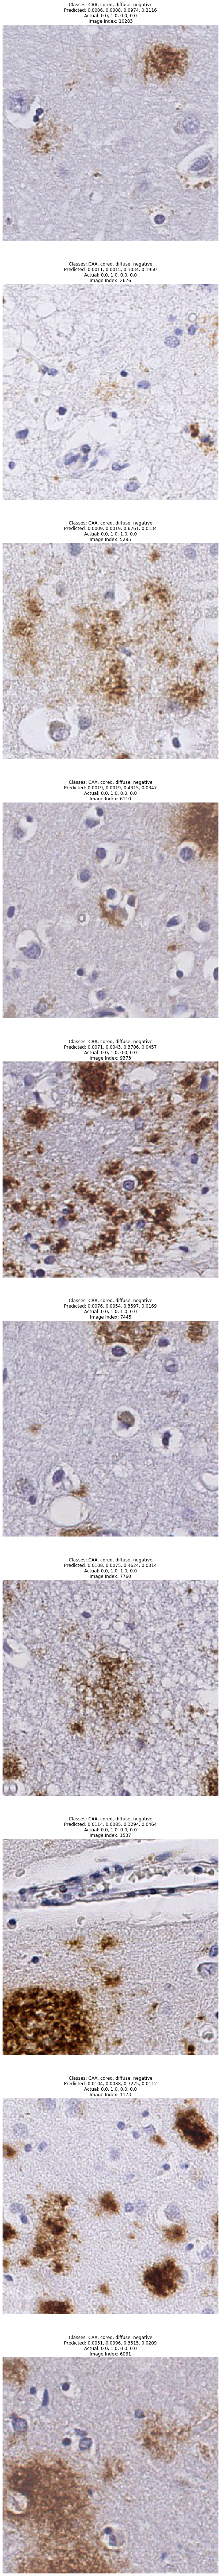

CAA     cored   diffuse  negative      loss
10283  0.000603  7.133611  0.102465  0.237724  7.474402
2676   0.001099  6.505403  0.109130  0.216888  6.832520
5285   0.000877  6.290917  0.391436  0.013467  6.696696
6110   0.001914  6.279221  0.564797  0.035368  6.881299
9373   0.007091  5.445730  0.462936  0.046769  5.962526
7445   0.007606  5.212494  1.022481  0.017060  6.259641
7760   0.010835  4.894237  0.771233  0.031883  5.708188
1537   0.011485  4.766360  0.399570  0.047488  5.224904
1173   0.010463  4.727637  1.300086  0.011221  6.049407
6061   0.005113  4.650230  0.433145  0.021146  5.109635

In [64]:
plot_top_losses(preds=test_preds,
                y=test_y,
                losses=test_losses,
                learner=learn,
                target_class='cored')

In [60]:
metrics['test'] = {**metrics['test'], **calc_threshold_metric_score(y=test_y,
                                                                    preds=test_preds,
                                                                    metrics=threshold_metrics)}

In [50]:
for class_idx in range(0, len(learn.data.classes)):
    name = f'accuracy_{learn.data.classes[class_idx]}_@threshold_{threshold}'
    metrics['test'][name] = accuracy_score(y[:,class_idx],
                                           preds[:,class_idx] > threshold)

In [62]:
from pprint import pprint
pprint(metrics)

{'test': {'AUPRC_#CAA': 0.1374962395106034,
          'AUPRC_#cored': 0.48123591372851204,
          'AUPRC_#diffuse': 0.9959224790252015,
          'AUPRC_#negative': 0.5436129899523122,
          'AUROC_#CAA': 0.9985200258995467,
          'AUROC_#cored': 0.9712957913638275,
          'AUROC_#diffuse': 0.9305096479708028,
          'AUROC_#negative': 0.937088993957782,
          'accuracy_score_@0.05': 0.9423076923076923,
          'accuracy_score_@0.10': 0.9614460059171598,
          'accuracy_score_@0.15': 0.9630177514792899,
          'accuracy_score_@0.20': 0.9572855029585798,
          'accuracy_score_@0.25': 0.9512758875739645,
          'accuracy_score_@0.30': 0.9431397928994083,
          'accuracy_score_@0.35': 0.932137573964497,
          'accuracy_score_@0.40': 0.9117048816568047,
          'accuracy_score_@0.45': 0.8705621301775148,
          'accuracy_score_@0.50': 0.8032544378698225,
          'accuracy_score_@0.55': 0.7058062130177515,
          'accuracy_score_@0.60':